# Rotations and transmission lines

On a lossless transmission line, moving along the line changes the phase of the reflection coefficient.

If the load reflection coefficient is \(\Gamma_L\), then at a distance \(l\) from the load (toward the generator):

\[
\Gamma(l) = \Gamma_L e^{-j 2 \beta l}
\]

where \(\beta = 2\pi/\lambda\).

Key implications:

- **Moving along the line rotates \(\Gamma\)**.
- The rotation is **clockwise** when moving **toward the generator** (decreasing phase).
- The pattern is **half-wavelength periodic** because of the factor \(2\beta l\).

This notebook shows how to visualize these ideas on a Smith chart using `pysmithchart`.

In [1]:
%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == "emscripten":
    import piplite

    await piplite.install("pysmithchart")

import pysmithchart
from pysmithchart.constants import REFLECTANCE_DOMAIN, IMPEDANCE_DOMAIN, ABSOLUTE_DOMAIN
from pysmithchart import utils

## 1. Rotation in the \(\Gamma\) plane (REFLECTANCE_DOMAIN)

In `REFLECTANCE_DOMAIN`, the Smith chart data are literally \(\Gamma\).
So moving along the line is a simple complex rotation.

We start with a load reflection coefficient \(\Gamma_L\) and rotate it by a sequence of electrical lengths.

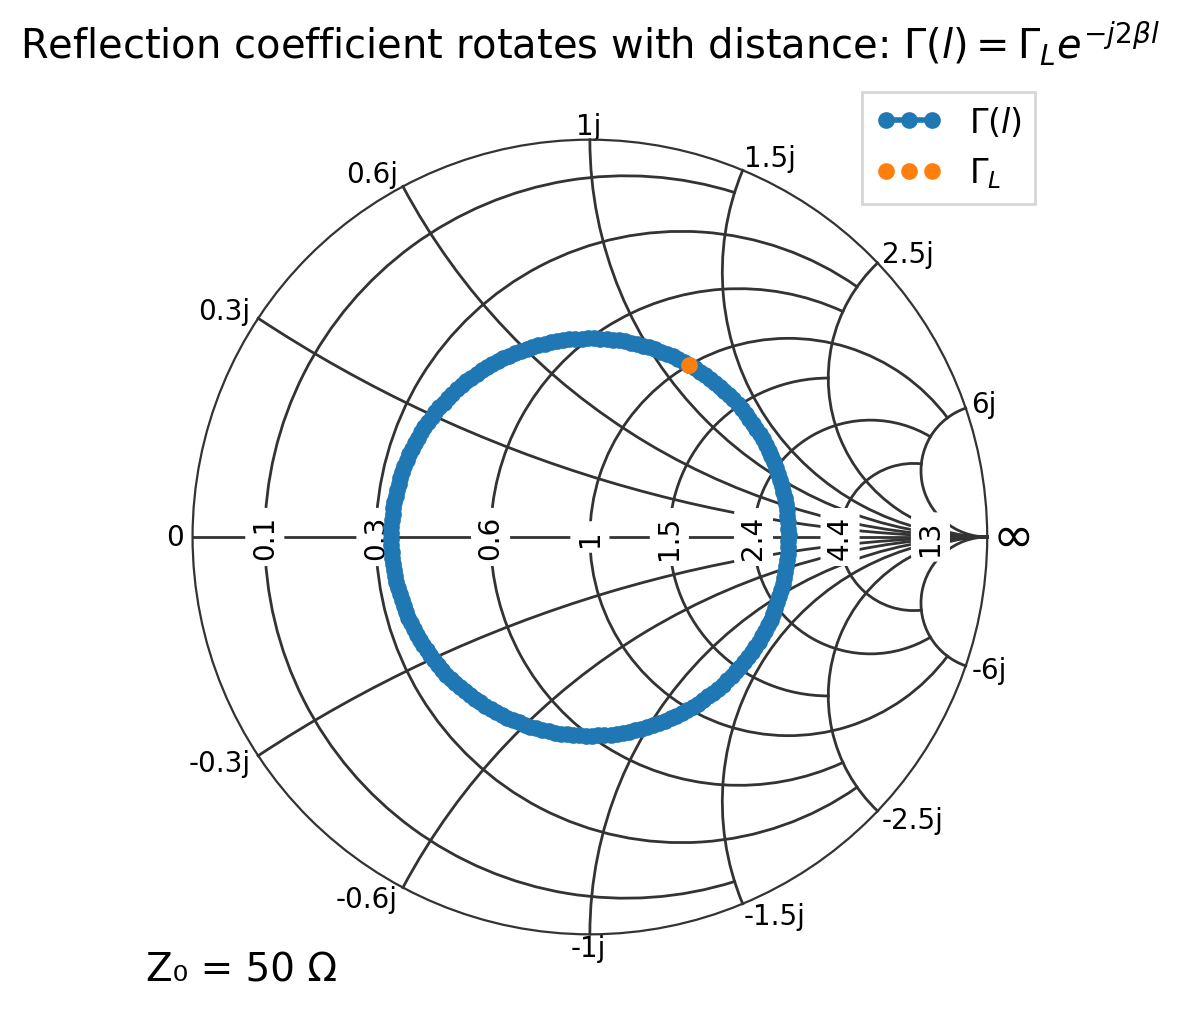

In [9]:
Gamma_L = 0.5 * np.exp(1j * np.deg2rad(60))  # example load reflection coefficient
l_over_lambda = np.linspace(0, 0.5, 201)  # 0 to half-wavelength

# Toward generator: Gamma(l) = Gamma_L * exp(-j 4 pi (l/lambda))
Gamma = Gamma_L * np.exp(-1j * 4 * np.pi * l_over_lambda)

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=REFLECTANCE_DOMAIN)
ax.plot(Gamma, label=r"$\Gamma(l)$")
ax.plot([Gamma_L], "o", label=r"$\Gamma_L$")

ax.legend(loc="upper right")
ax.set_title(r"Reflection coefficient rotates with distance: $\Gamma(l)=\Gamma_L e^{-j2\beta l}$")
plt.show()

### Direction: toward generator is clockwise

If we parameterize \(l\) increasing from the load toward the generator, the exponential term \(e^{-j2\beta l}\) rotates **clockwise**.

We will label a few points at eighth-wave intervals.

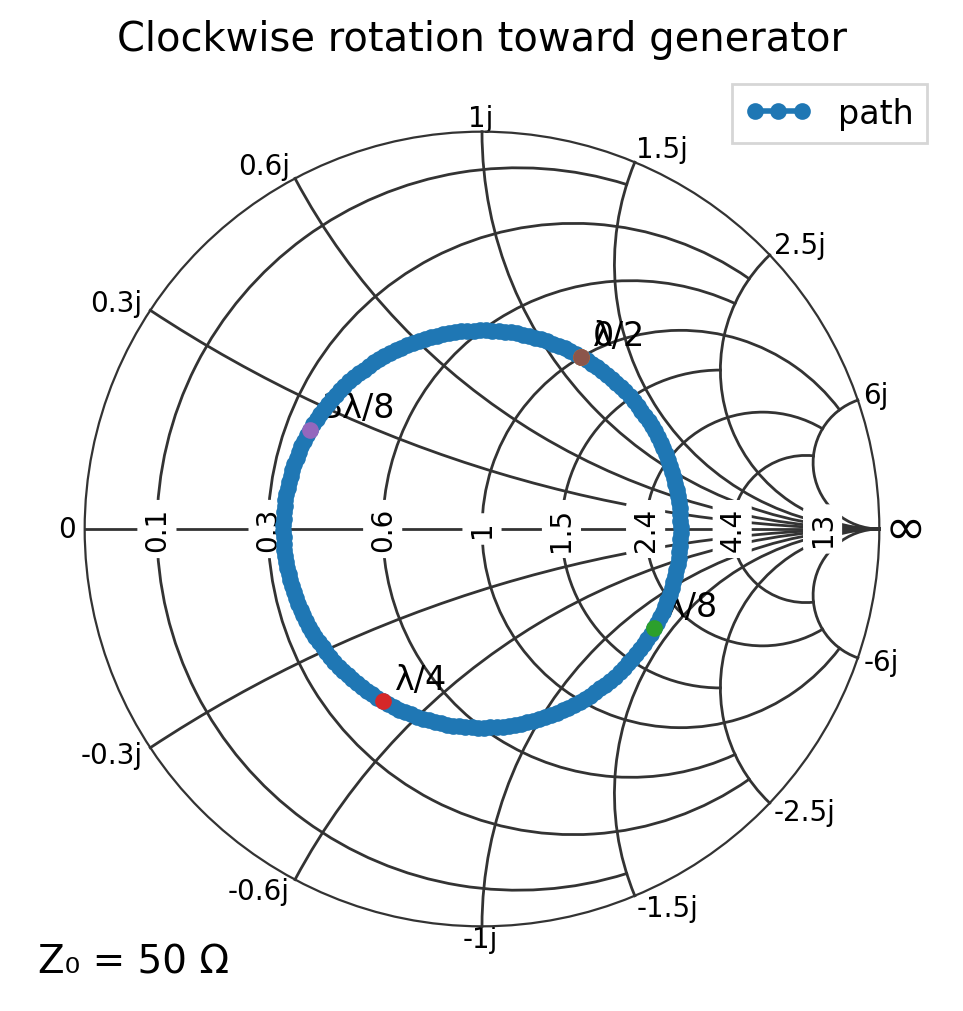

In [10]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=REFLECTANCE_DOMAIN)

ax.plot(Gamma, label="path")

for frac, label in [(0.0, "0"), (0.125, "λ/8"), (0.25, "λ/4"), (0.375, "3λ/8"), (0.5, "λ/2")]:
    Gp = Gamma_L * np.exp(-1j * 4 * np.pi * frac)
    ax.plot([Gp], "o")
    ax.text(Gp.real + 0.03, Gp.imag + 0.03, label)

ax.legend(loc="upper right")
ax.set_title("Clockwise rotation toward generator")
plt.show()

## 2. Half-wavelength periodicity

Because the phase rotation is \(2\beta l\), moving by \(\lambda/2\) produces a \(2\pi\) phase change in \(\Gamma\):

\[
\Gamma\left(l+\frac{\lambda}{2}\right) = \Gamma(l)
\]

So the impedance pattern repeats every half-wavelength along a lossless line.

We can show this by plotting \(\Gamma(l)\) from 0 to \(\lambda\), and noting the path is traced twice.

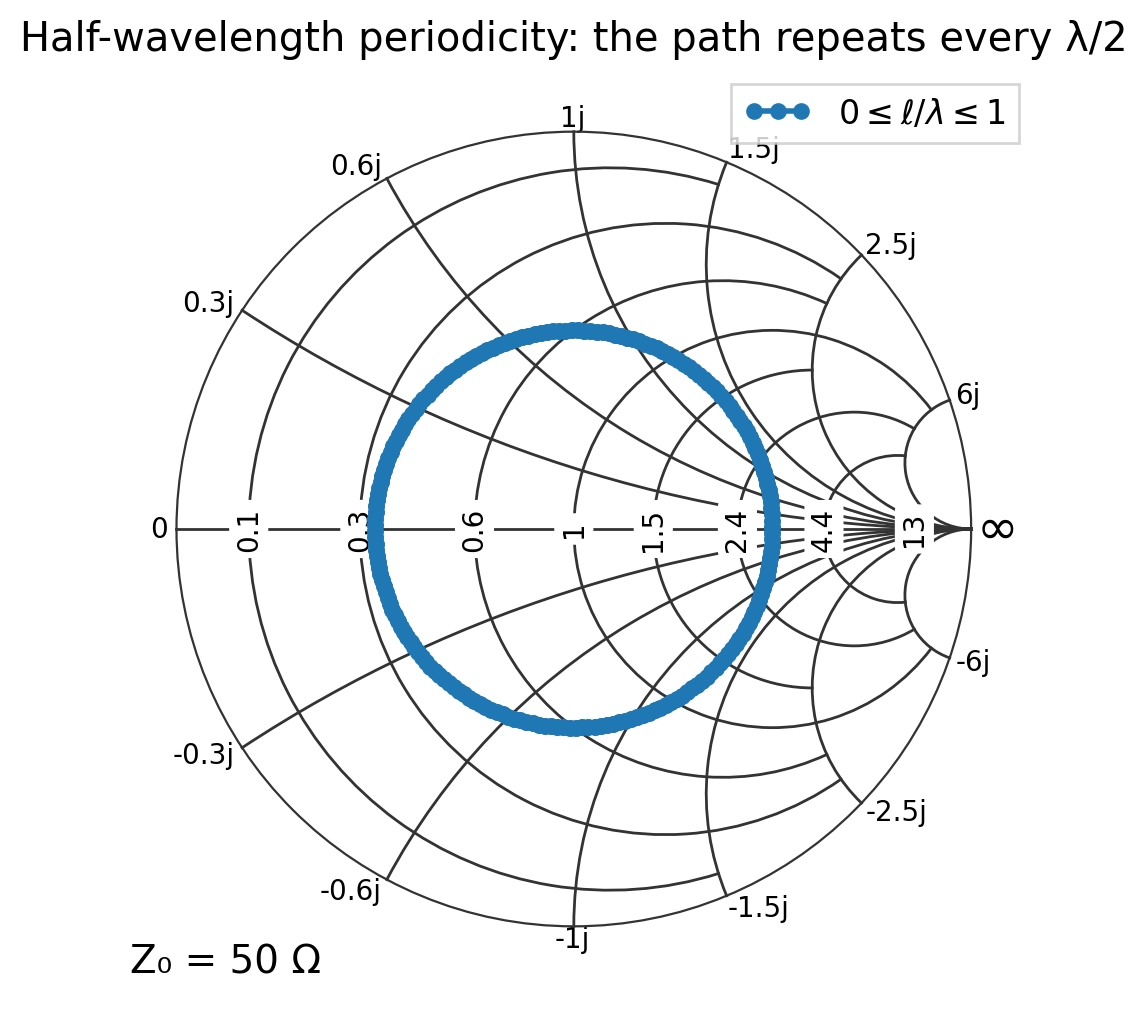

In [12]:
l_over_lambda2 = np.linspace(0, 1.0, 401)
Gamma2 = Gamma_L * np.exp(-1j * 4 * np.pi * l_over_lambda2)

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=REFLECTANCE_DOMAIN)
ax.plot(Gamma2, label=r"$0 \leq \ell/\lambda \leq 1$")
ax.legend(loc="upper right")
ax.set_title("Half-wavelength periodicity: the path repeats every λ/2")
plt.show()

## 3. The same motion in impedance coordinates (IMPEDANCE_DOMAIN)

Many engineers think in terms of impedance \(Z\) rather than \(\Gamma\).
We can convert \(\Gamma(l)\) into the corresponding input impedance:

\[
Z(l) = Z_0 \frac{1+\Gamma(l)}{1-\Gamma(l)}
\]

In `IMPEDANCE_DOMAIN`, `pysmithchart` expects impedances in **ohms** and normalizes internally by \(Z_0\).

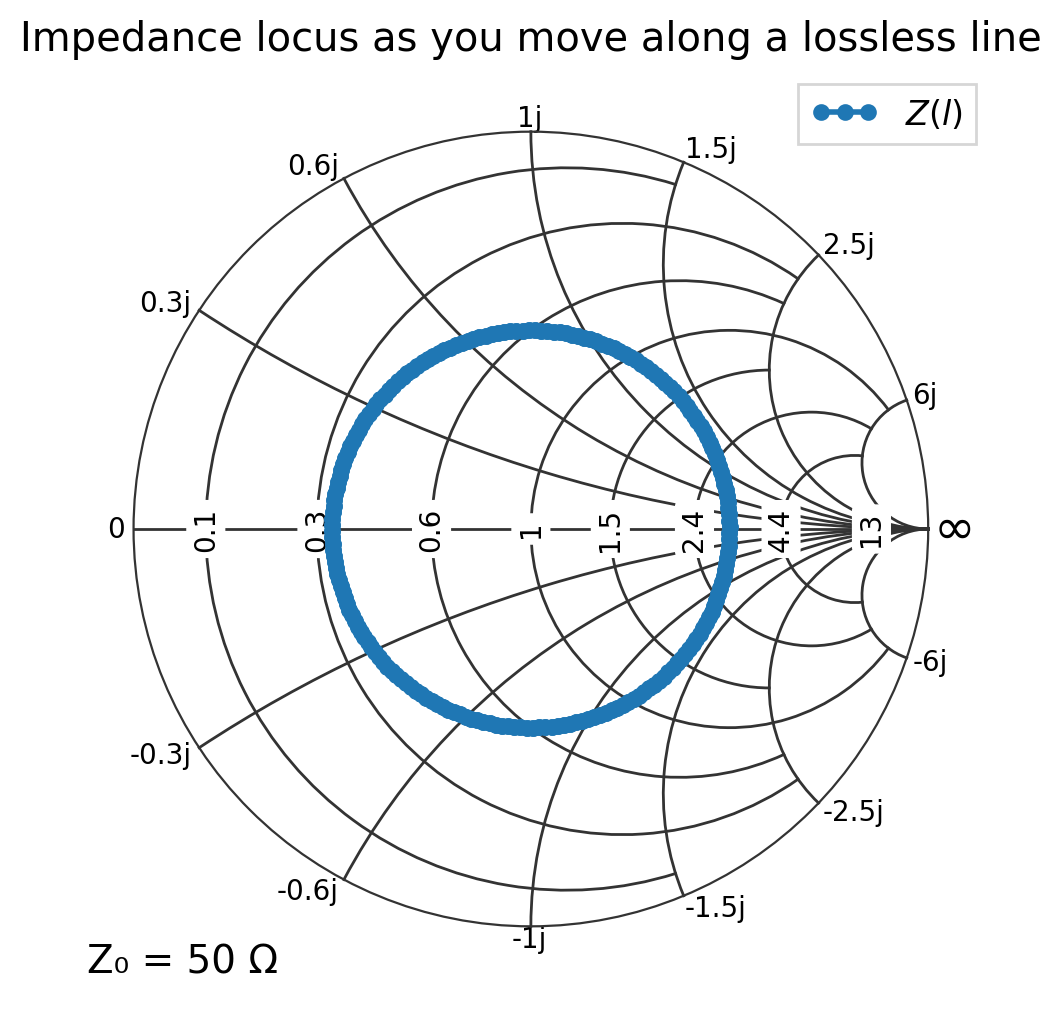

In [13]:
Z0 = 50
Z_in = utils.calc_load(Z0, Gamma2)  # impedance corresponding to Gamma(l)

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", Z0=Z0, domain=IMPEDANCE_DOMAIN)

ax.plot(Z_in, label=r"$Z(l)$")
ax.legend(loc="upper right")
ax.set_title("Impedance locus as you move along a lossless line")
plt.show()

## 4. Rotate “toward generator” vs “toward load”

The sign convention matters.

- Toward generator: \(\Gamma(l) = \Gamma_L e^{-j2\beta l}\)
- Toward load: \(\Gamma(l) = \Gamma_L e^{+j2\beta l}\)

If your path appears to rotate the “wrong way,” check your direction and sign convention.

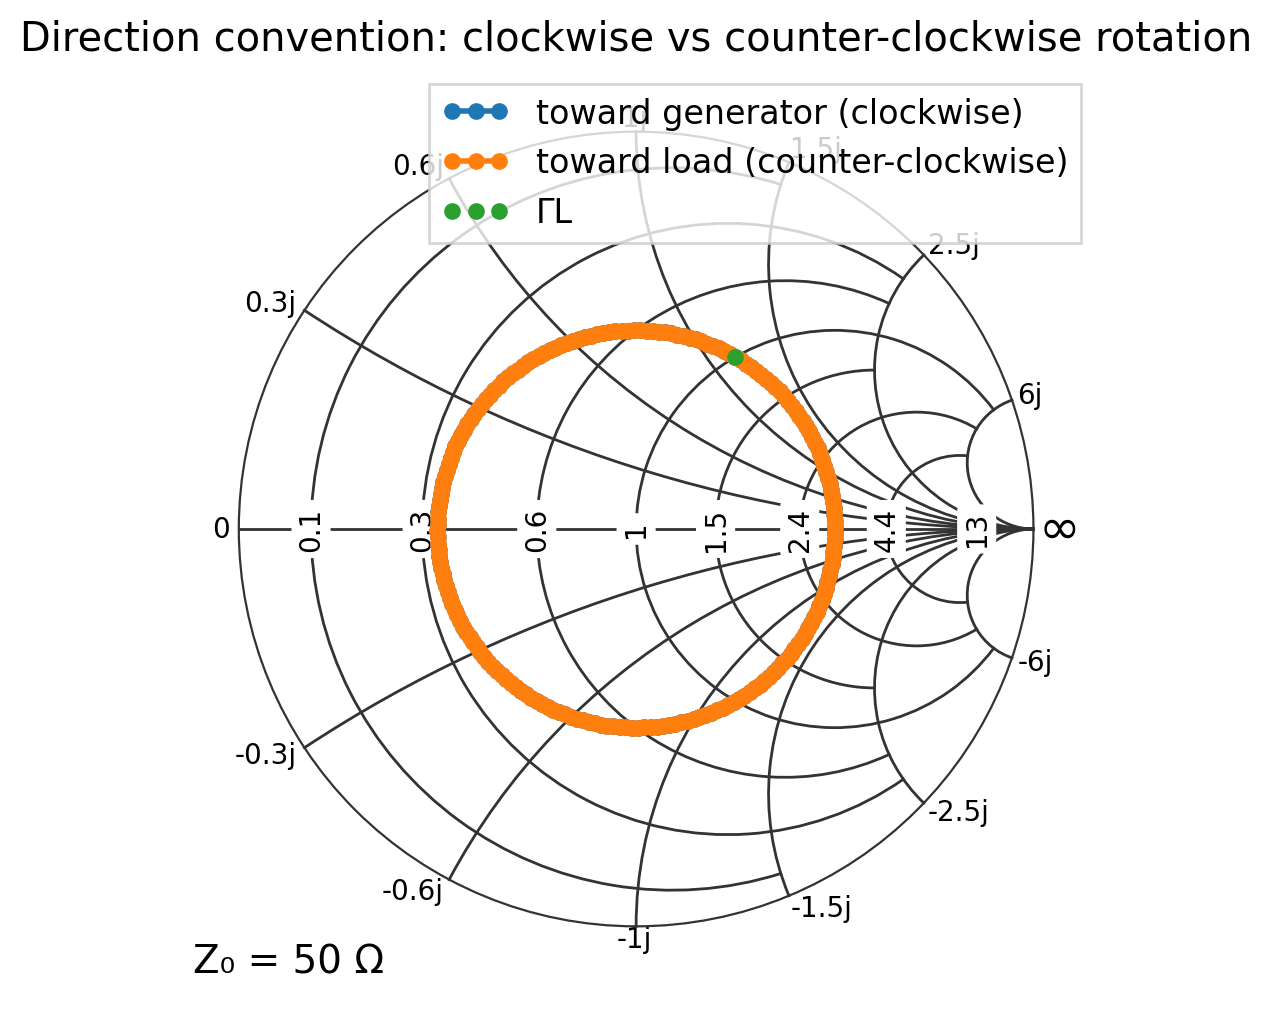

In [14]:
l = np.linspace(0, 0.5, 201)

Gamma_toward_gen = Gamma_L * np.exp(-1j * 4 * np.pi * l)
Gamma_toward_load = Gamma_L * np.exp(+1j * 4 * np.pi * l)

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=REFLECTANCE_DOMAIN)

ax.plot(Gamma_toward_gen, label="toward generator (clockwise)")
ax.plot(Gamma_toward_load, label="toward load (counter-clockwise)")
ax.plot([Gamma_L], "o", label="ΓL")

ax.legend(loc="upper right")
ax.set_title("Direction convention: clockwise vs counter-clockwise rotation")
plt.show()

## 5. Quarter-wave transformer example

A classic result: a **lossless quarter-wave section** transforms impedances according to:

\[
Z_{\mathrm{in}} = \frac{Z_0^2}{Z_L}
\]

This is the special case of the general transmission-line input impedance formula when \(l=\lambda/4\).

We can compute this by rotating \(\Gamma\) by \(180^\circ\) (since \(2\beta(\lambda/4) = \pi\)) and converting back to impedance.

In [15]:
Z0 = 50
ZL = 100 + 0j

Gamma_L2 = utils.calc_gamma(Z0, ZL)

# Quarter-wave toward generator: rotate Gamma by -pi
Gamma_qw = Gamma_L2 * np.exp(-1j * np.pi)
Zin_qw = utils.calc_load(Z0, Gamma_qw)

# Compare with Z0^2/ZL
Zin_qw_formula = Z0**2 / ZL

Zin_qw, Zin_qw_formula

(np.complex128(25-2.296212748401287e-15j), (25+0j))

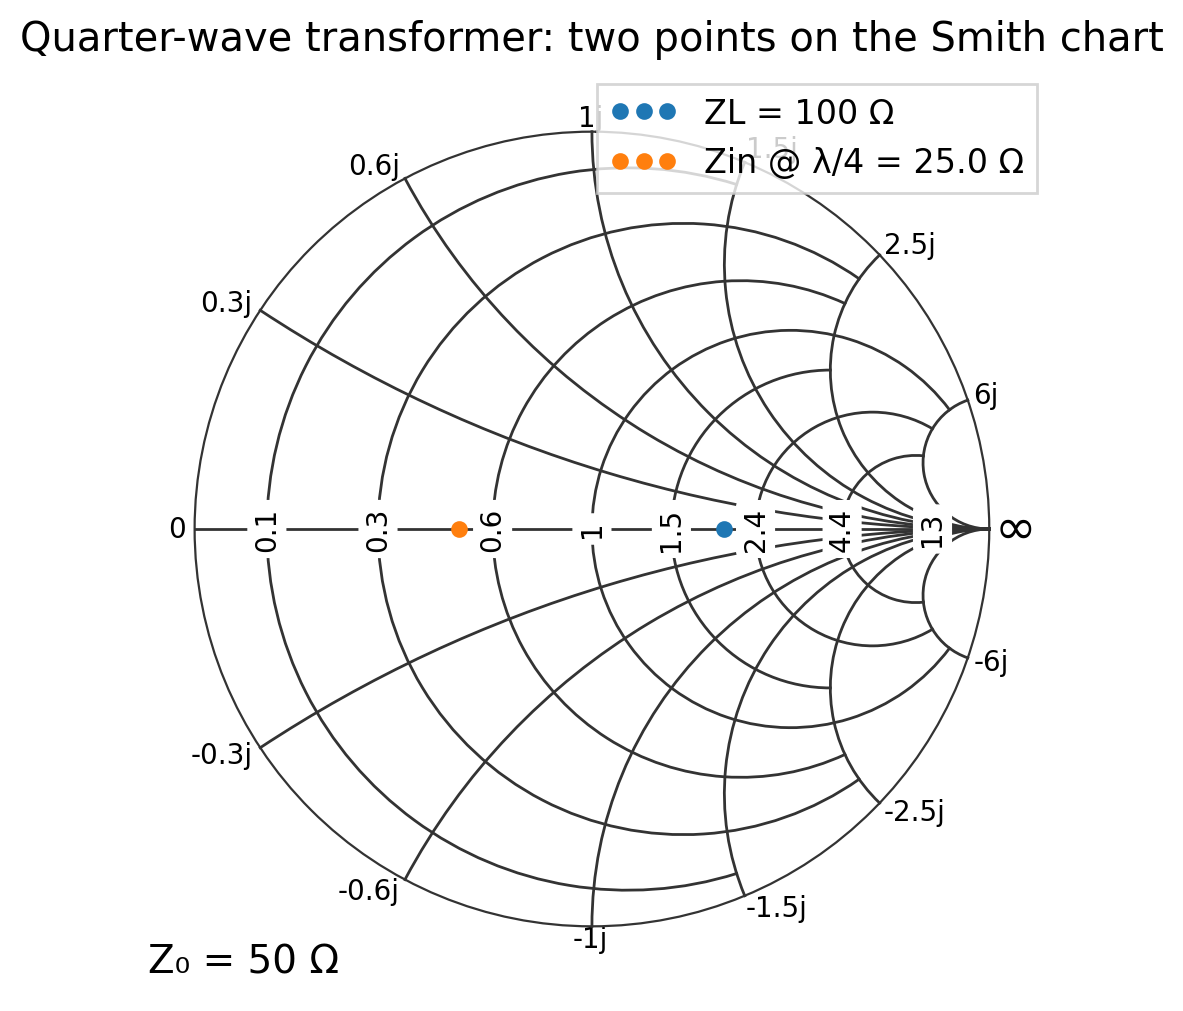

In [16]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", Z0=Z0)

ax.plot([ZL], "o", label=f"ZL = {ZL.real:.0f} Ω")
ax.plot([Zin_qw], "o", label=f"Zin @ λ/4 = {Zin_qw.real:.1f} Ω")

ax.legend(loc="upper right")
ax.set_title("Quarter-wave transformer: two points on the Smith chart")
plt.show()

## 6. Summary

- Moving along a lossless line rotates the reflection coefficient: \(\Gamma(l)=\Gamma_L e^{-j2\beta l}\).
- Toward generator corresponds to **clockwise** rotation on the Smith chart in \(\Gamma\)-space.
- The impedance pattern repeats every **half-wavelength**.
- You can plot the same motion in `REFLECTANCE_DOMAIN` (\(\Gamma\)) or `IMPEDANCE_DOMAIN` (\(Z\) in ohms).

Next recommended notebook: **arrows_and_paths**.